In [19]:
import os

import matplotlib.pyplot as plt
import numpy
import scipy.fftpack

if not os.path.exists('thinkdsp.py'):
    from urllib.request import urlretrieve

    urlretrieve("https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py", "thinkdsp.py")

from thinkdsp import decorate, read_wave, UncorrelatedGaussianNoise, Spectrogram
from scipy.stats import linregress

### Упражнение 6.1
`analyze` и `analyze2`

Создание шумового сигнала


In [20]:
signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1, framerate=16384)

Функция `plot_bests` для отображения массива результата
Функция `run_speed_test`

In [21]:
def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(xscale='log', yscale='log')

    x = numpy.log(ns)
    y = numpy.log(bests)
    t = linregress(x,y)
    slope = t[0]
    return slope

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + numpy.arange(N)) / N
        freqs = (0.5 + numpy.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

Функция `analyze1`

In [22]:
PI2 = numpy.pi * 2

def analyze1(ys, fs, ts):
    args = numpy.outer(ts, fs)
    M = numpy.cos(PI2 * args)
    amps = numpy.linalg.solve(M, ys)
    return amps


Подготовка данных для `analyze1`


In [23]:
ns = 2 ** numpy.arange(7, 14)
ns

array([ 128,  256,  512, 1024, 2048, 4096, 8192], dtype=int32)

Тестирование `analyze1`

128
1.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
256
1.89 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
12.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
75.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
368 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
13.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.2958213898773305

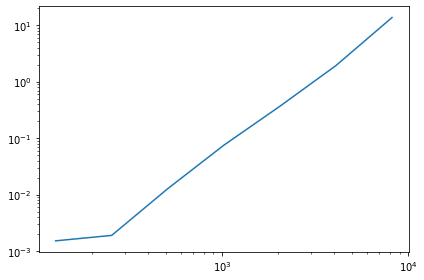

In [24]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Функция `analyze2`

In [25]:
def analyze2(ys, fs, ts):
    args = numpy.outer(ts, fs)
    M = numpy.cos(PI2 * args)
    amps = numpy.dot(M, ys) / 2
    return amps

Тестирование `analyze2`


128
249 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
904 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
5.46 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
24.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
86.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
368 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
1.46 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1029186041497256

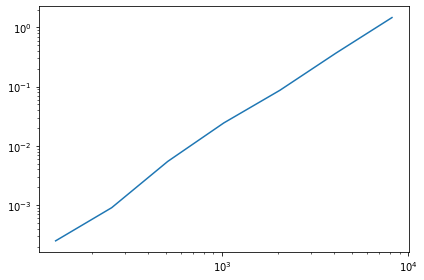

In [26]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)


Функция `scipy_dct`

In [27]:
def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)


Тестирование `scipy_dct`

128
10.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
11.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
13.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
17.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
23.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
43.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
8192
88.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.49092558234769135

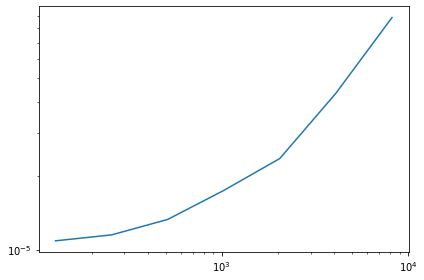

In [28]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

Все три результата

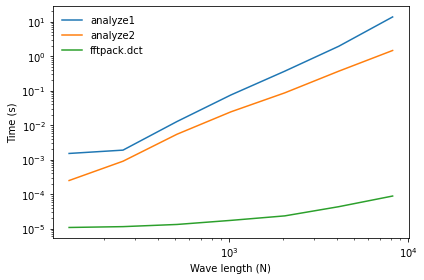

In [29]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', xscale='log', yscale='log')

### Упражнение 6.2
ДКП для сжатия звука

Чтение файла и получение `wave`

In [30]:
guitar_wave = read_wave('resources/Sounds/task2_serylis_guitar_chord.wav')
guitar_wave.make_audio()

Выбор сегмента

In [31]:
guitar_segment = guitar_wave.segment(start=0.7, duration=0.5)
guitar_segment.normalize()
guitar_segment.make_audio()

Получение ДКП сегмента

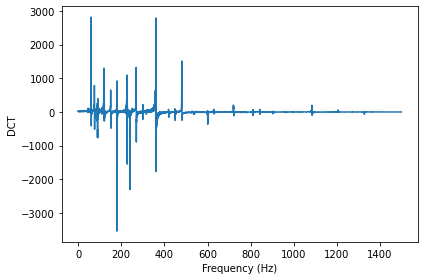

In [32]:
guitar_dct = guitar_segment.make_dct()
guitar_dct.plot(high=1500)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Функция `compress` для сжатия

In [33]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if numpy.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применение функции

20975	22050	95.12471655328798


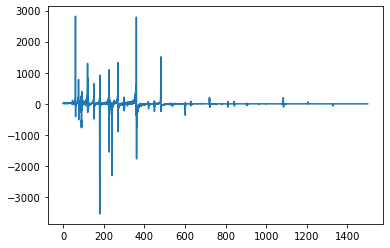

In [34]:
guitar_dct = guitar_segment.make_dct()
compress(guitar_dct, thresh=10)
guitar_dct.plot(high=1500)
guitar_segment2 = guitar_dct.make_wave()
guitar_segment2.make_audio()

Функция для сжатия большого сегмента

In [35]:
def make_dct_spectrogram(wave, seg_length):
    window = numpy.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Сжатие всего сегмента

In [36]:
guitar_spectrogram = make_dct_spectrogram(guitar_wave, seg_length=1024)
for t, dct in sorted(guitar_spectrogram.spec_map.items()):
    compress(dct, thresh=0.2)

755	1024	73.73046875
821	1024	80.17578125
859	1024	83.88671875
882	1024	86.1328125
889	1024	86.81640625
882	1024	86.1328125
890	1024	86.9140625
896	1024	87.5
904	1024	88.28125
877	1024	85.64453125
875	1024	85.44921875
872	1024	85.15625
853	1024	83.30078125
809	1024	79.00390625
812	1024	79.296875
862	1024	84.1796875
584	1024	57.03125
536	1024	52.34375
620	1024	60.546875
774	1024	75.5859375
807	1024	78.80859375
814	1024	79.4921875
799	1024	78.02734375
822	1024	80.2734375
826	1024	80.6640625
839	1024	81.93359375
853	1024	83.30078125
848	1024	82.8125
853	1024	83.30078125
856	1024	83.59375
860	1024	83.984375
852	1024	83.203125
864	1024	84.375
868	1024	84.765625
874	1024	85.3515625
869	1024	84.86328125
879	1024	85.83984375
882	1024	86.1328125
877	1024	85.64453125
876	1024	85.546875
885	1024	86.42578125
879	1024	85.83984375
889	1024	86.81640625
890	1024	86.9140625
891	1024	87.01171875
886	1024	86.5234375
899	1024	87.79296875
891	1024	87.01171875
890	1024	86.9140625
899	1024	87.79296875
899	10

Аудио после сжатия

In [37]:
guitar_wave2 = guitar_spectrogram.make_wave()
guitar_wave2.make_audio()

Аудио до сжатия

In [38]:
guitar_wave.make_audio()

### Упражнение 6.3
Фаза

Необходимые функции

In [39]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = numpy.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', ylabel='Phase (radian)')

def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= numpy.exp(1j * offset)
    return res

def random_angle(spectrum):
    res = spectrum.copy()
    angles = numpy.random.uniform(0, PI2, len(spectrum))
    res.hs *= numpy.exp(1j * angles)
    return res

Чтение файла

In [40]:
oboe_wave = read_wave('resources/Sounds/task3_thirsk_120_oboe.wav')
oboe_wave.make_audio()

Выбор сегмента, отличного от использующегося в примере

In [41]:
oboe_segment = oboe_wave.segment(start=2.1, duration=1)
oboe_segment.make_audio()

Получение спектра, угловой части спектра и `wave`

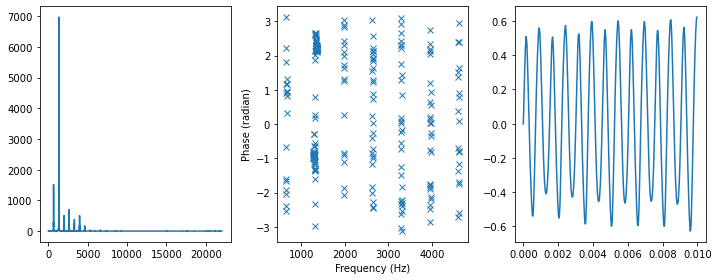

In [42]:
oboe_spectrum = oboe_segment.make_spectrum()
plot_three(oboe_spectrum, thresh=50)

Угол на 0


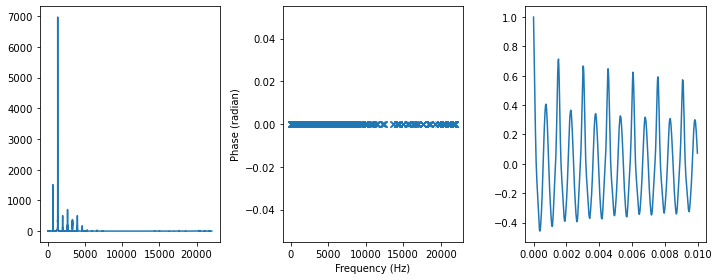

In [43]:
oboe_spectrum2 = zero_angle(oboe_spectrum)
plot_three(oboe_spectrum2)

Поворот угла на 1 радиану

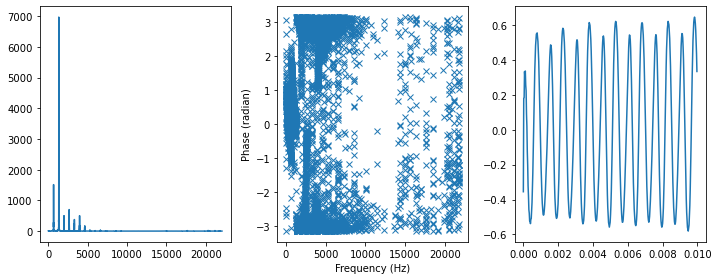

In [44]:
oboe_spectrum3 = rotate_angle(oboe_spectrum, 1)
plot_three(oboe_spectrum3)

Установка случайных значений

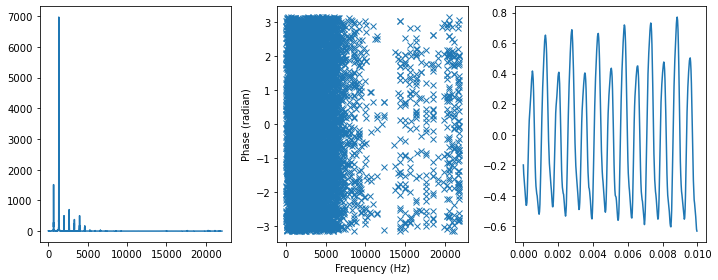

In [45]:
oboe_spectrum4 = random_angle(oboe_spectrum)
plot_three(oboe_spectrum4)
